In [6]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
plt.style.use('bmh')

os.chdir('/project/lcd_v2/')

In [12]:
# get transistor meta-data
!cd .cache/sim_data && wget -N https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/transistors.csv

--2023-04-03 21:40:03--  https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/transistors.csv
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.242.80, 52.218.184.96, 3.5.87.127, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.242.80|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘transistors.csv’ not modified on server. Omitting download.



In [28]:
interval = 10
step_limit = 400
num_iterations = 256
window = '768_1024'
root_dir = '.cache/sim_data'

In [50]:
# helper functions
def get_cmap_slice(cmap, start, stop, n=256, name='my_slice'):
    return colors.LinearSegmentedColormap.from_list(name, cmap(np.linspace(start, stop, cmap.N)),N=n)

def get_perturb_config(window):
    # perturb at the middle of the interation_time
    perturb_timepoint = num_iterations // 2
    current_voltages = window[:, step_limit * perturb_timepoint]
    # 0: 'low', 1: 'high'
    perturb_types = np.where(current_voltages == 1, 0, 1)
    perturb_config = {tidx: (perturb_timepoint, perturb_types[tidx]) for tidx in range(len(current_voltages))
                      if window[tidx].std() != 0}
    return perturb_config

# get geometry information of transistors
ts_info = pd.read_csv(os.path.join(os.path.dirname(root_dir), 'transistors.csv'))

def get_strength(kwargs):
    idx, game = kwargs['idx'], kwargs['game']
    if isinstance(idx, int):
        orig = np.load(os.path.join(root_dir, f'{game}/HR/window_{window}/Regular_3510_step_256_rec_400_window_{window}.npy'), mmap_mode='r')
        potential_resultant = []
        unique_perturb = get_perturb_config(orig)
        perturb = np.load(os.path.join(root_dir, f"{game}/HR/window_{window}/Perturb_3510_step_{window.split('_')[-1]}_tidx_{idx}.npy"), mmap_mode='r')
        print(idx, perturb.shape, orig[idx].std())
        # padding to the fix length of one half-clock, last point is marker (-1)
        if perturb.shape[1] > step_limit:
            padded_perturb = perturb[:, :step_limit]
        else:
            padded_perturb = np.concatenate(
                (perturb[:, :-1], np.tile(perturb[:, -2].reshape(-1, 1), step_limit - perturb.shape[1] + 1)),
                axis=1)

        perturb_timepoint = unique_perturb[idx][0]
        for i in range(3510):
            # compare the regular state and 'perturbed' state when the cause transistor (idx) is perturbed
            # skip the cause transistor itself and the transistor has constant value
            if orig[i].std() != 0 and i != idx:
                # detect the first point where the perturbation actually works
                causal_effect = np.abs((padded_perturb[i] - orig[i, perturb_timepoint*step_limit:(perturb_timepoint+1)*step_limit])).mean()
                potential_resultant.append(causal_effect)
            else:
                potential_resultant.append(0)
        return potential_resultant
    else:
        assert isinstance(idx, list), 'idx must be an integer or a list of integers'
    with mp.Pool(mp.cpu_count()) as pool:
        potential_resultant = pool.map(get_strength, [{'idx': i, 'game': game} for i in idx])
        potential_resultant = iter(np.mean(potential_resultant, axis=-1).tolist())
        potential_resultant = [next(potential_resultant) if i in idx else 0 for i in range(3510)]
    return potential_resultant

def plot_cause_effect(target_idx, save_dir=None):
    games = ['DonkeyKong', 'Pitfall', 'SpaceInvaders']
    effect = {game: get_strength({'idx': target_idx, 'game': game}) for game in games}
    max_effect = np.max([_effect for t_effect in effect.values() for _effect in t_effect])
    fig, axs = plt.subplots(1, len(games), figsize=(len(games)*10, 10), sharex=True, sharey=True)
    cmap = get_cmap_slice(plt.get_cmap("Reds"), 0.2, 1.0)
    for idx, (game, _effect) in enumerate(effect.items()):
        # Normalize the causal effect
        if max_effect != 0:
            causal_effect = np.array(_effect) / max_effect
        else:
            causal_effect = np.array(_effect)
        # Heatmap of causal effect
        im = axs[idx].scatter(ts_info.x, ts_info.y, c=causal_effect, cmap=cmap, edgecolor='none', vmin=0, vmax=1)
        if not isinstance(target_idx, list) and not isinstance(target_idx, str):
            axs[idx].scatter(ts_info.x.iloc[target_idx], ts_info.y.iloc[target_idx], c='blue', s=10**2, edgecolor='none')
        axs[idx].tick_params(axis='x', labelsize=12)
        axs[idx].tick_params(axis='y', labelsize=12)
        axs[idx].set_title(game, fontdict={'family': 'Serif'}, fontsize=30)

    fig.set_facecolor('w')
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.05)
    fig.text(0.45, 0.05, "X Position (um)", fontdict={'family': 'Serif'}, size=20)
    fig.text(0.07, 0.5, "Y Position (um)", rotation='vertical', fontdict={'family': 'Serif'}, size=20)
    cbar = fig.colorbar(im, cax=plt.axes([0.82, 0.1, 0.02, 0.8]))
    cbar.set_label('Cause Effect Strength', fontdict={'family': 'Serif'}, size=20)
    cbar.set_ticks(ticks=np.arange(0.0, 1.0, 0.1))
    cbar.ax.tick_params(labelsize=10)
    fig.clim = (0.0, 1.0)
    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")


def plot_transistors(target_idx, save_dir=None):
    fig = plt.figure(figsize=(10, 10))
    # specific colors for target idx
    cls = iter(['#DE1334', '#FF414C', '#6752FF'])
    cmap = get_cmap_slice(plt.get_cmap("Reds"), 0.2, 1.0)
    c = [idx for idx in range(3510) if idx not in target_idx]
    # Heatmap of causal effect
    plt.scatter(ts_info.x[c], ts_info.y[c], c=[0]*len(c), cmap=cmap, edgecolor='none')
    for idx in target_idx:
        plt.scatter(ts_info.x[idx], ts_info.y[idx], c=next(cls), s=10**2, cmap=cmap, edgecolor='none', label=f'transistor {idx}')
    if not isinstance(target_idx, list) and not isinstance(target_idx, str):
        plt.scatter(ts_info.x.iloc[target_idx], ts_info.y.iloc[target_idx], c='blue', s=10**2, cmap=cmap, edgecolor='none')
    plt.xticks([])
    plt.yticks([])
    fig.clim = (0.0, 1.0)
    plt.legend()
    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")


In [53]:
adj = pickle.load(open(os.path.join(root_dir, f'DonkeyKong/HR/window_768_1024/adjacency_matrix.pkl'), 'rb'))
# sort the dict by the length of the value
adj = {k: v for k, v in sorted(adj.items(), key=lambda item: len(item[1]), reverse=True)}
adj

{1496: [9,
  17,
  18,
  24,
  32,
  33,
  39,
  73,
  117,
  125,
  140,
  142,
  181,
  243,
  260,
  261,
  296,
  311,
  335,
  336,
  402,
  451,
  472,
  520,
  541,
  542,
  581,
  582,
  713,
  790,
  890,
  925,
  926,
  1008,
  1036,
  1041,
  1049,
  1079,
  1114,
  1121,
  1185,
  1199,
  1205,
  1206,
  1264,
  1265,
  1270,
  1391,
  1407,
  1449,
  1558,
  1574,
  1578,
  1653,
  1684,
  1690,
  1703,
  1704,
  1716,
  1719,
  1732,
  1733,
  1752,
  1801,
  1823,
  1833,
  1882,
  1941,
  1988,
  2010,
  2042,
  2108,
  2115,
  2133,
  2194,
  2195,
  2247,
  2268,
  2327,
  2451,
  2514,
  2558,
  2587,
  2591,
  2602,
  2631,
  2632,
  2678,
  2679,
  2680,
  2724,
  2762,
  2811,
  2817,
  2824,
  2891,
  2935,
  2940,
  2943,
  3012,
  3337,
  3339,
  3342,
  3343,
  3344],
 1497: [9,
  17,
  18,
  24,
  32,
  33,
  39,
  73,
  117,
  125,
  140,
  142,
  181,
  243,
  260,
  261,
  296,
  311,
  335,
  336,
  402,
  451,
  472,
  520,
  541,
  542,
  581,
  582,
  

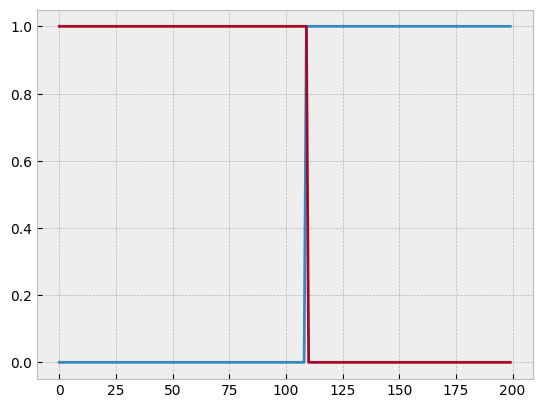

In [119]:
import matplotlib.pyplot as plt

orig = np.load(os.path.join(root_dir, f'DonkeyKong/HR/window_{window}/Regular_3510_step_256_rec_400_window_{window}.npy'), mmap_mode='r')
plt.plot(orig[1207, ][11900:12100])
plt.plot(orig[1177, ][11900:12100])

1496 (3510, 2) 0.49998474097809975
1496 (3510, 2) 0.49998474097809975
1496 (3510, 2) 0.49998474097809975


/tmp/ipykernel_2562/541596468.py:77: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, cax=plt.axes([0.82, 0.1, 0.02, 0.8]))


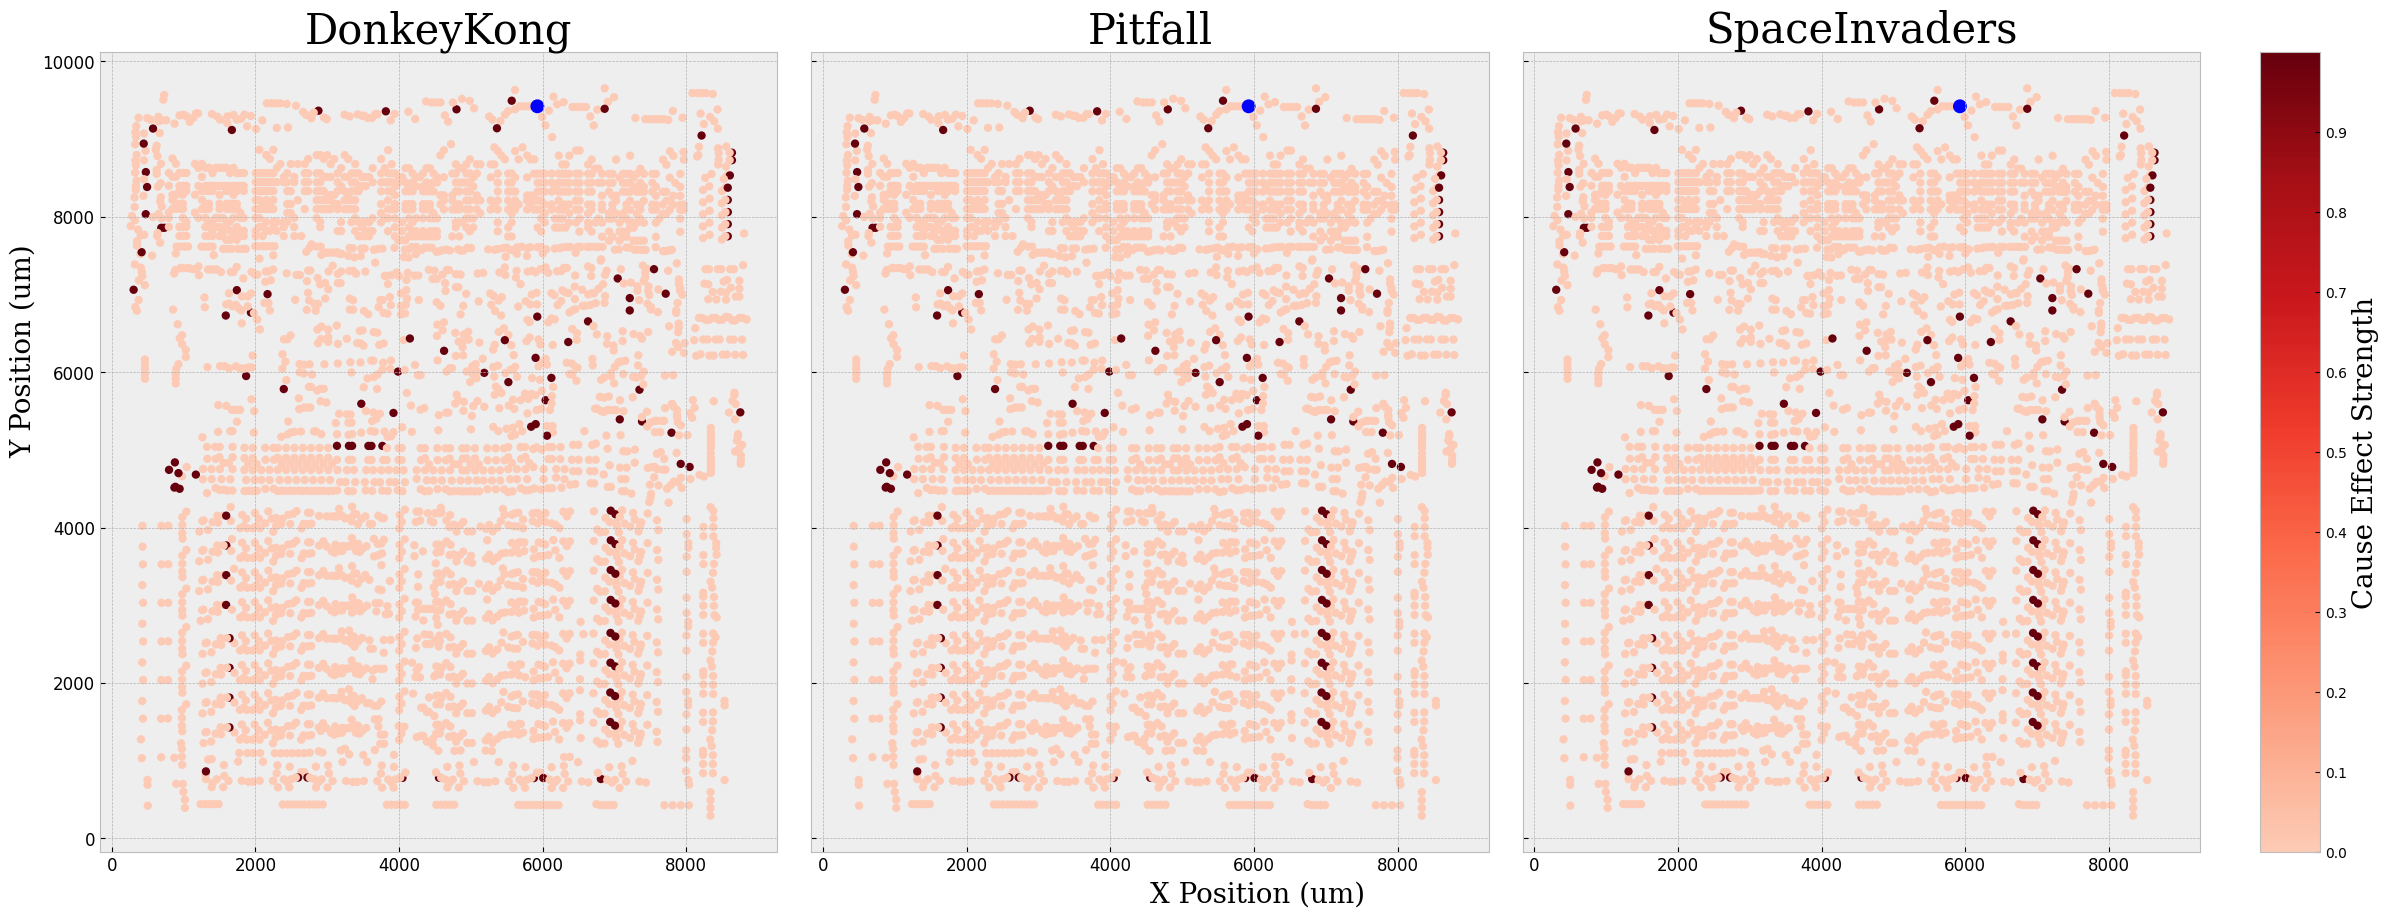

In [58]:
plot_cause_effect(target_idx=1496, save_dir='/project/lcd_v2/figure/Figure 2. Causal Effect/transistor_1496')

2328 (3510, 2) 0.4970088692992404
2328 (3510, 2) 0.49607837082461076
2328 (3510, 2) 0.4970088692992404


/tmp/ipykernel_2562/541596468.py:77: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, cax=plt.axes([0.82, 0.1, 0.02, 0.8]))


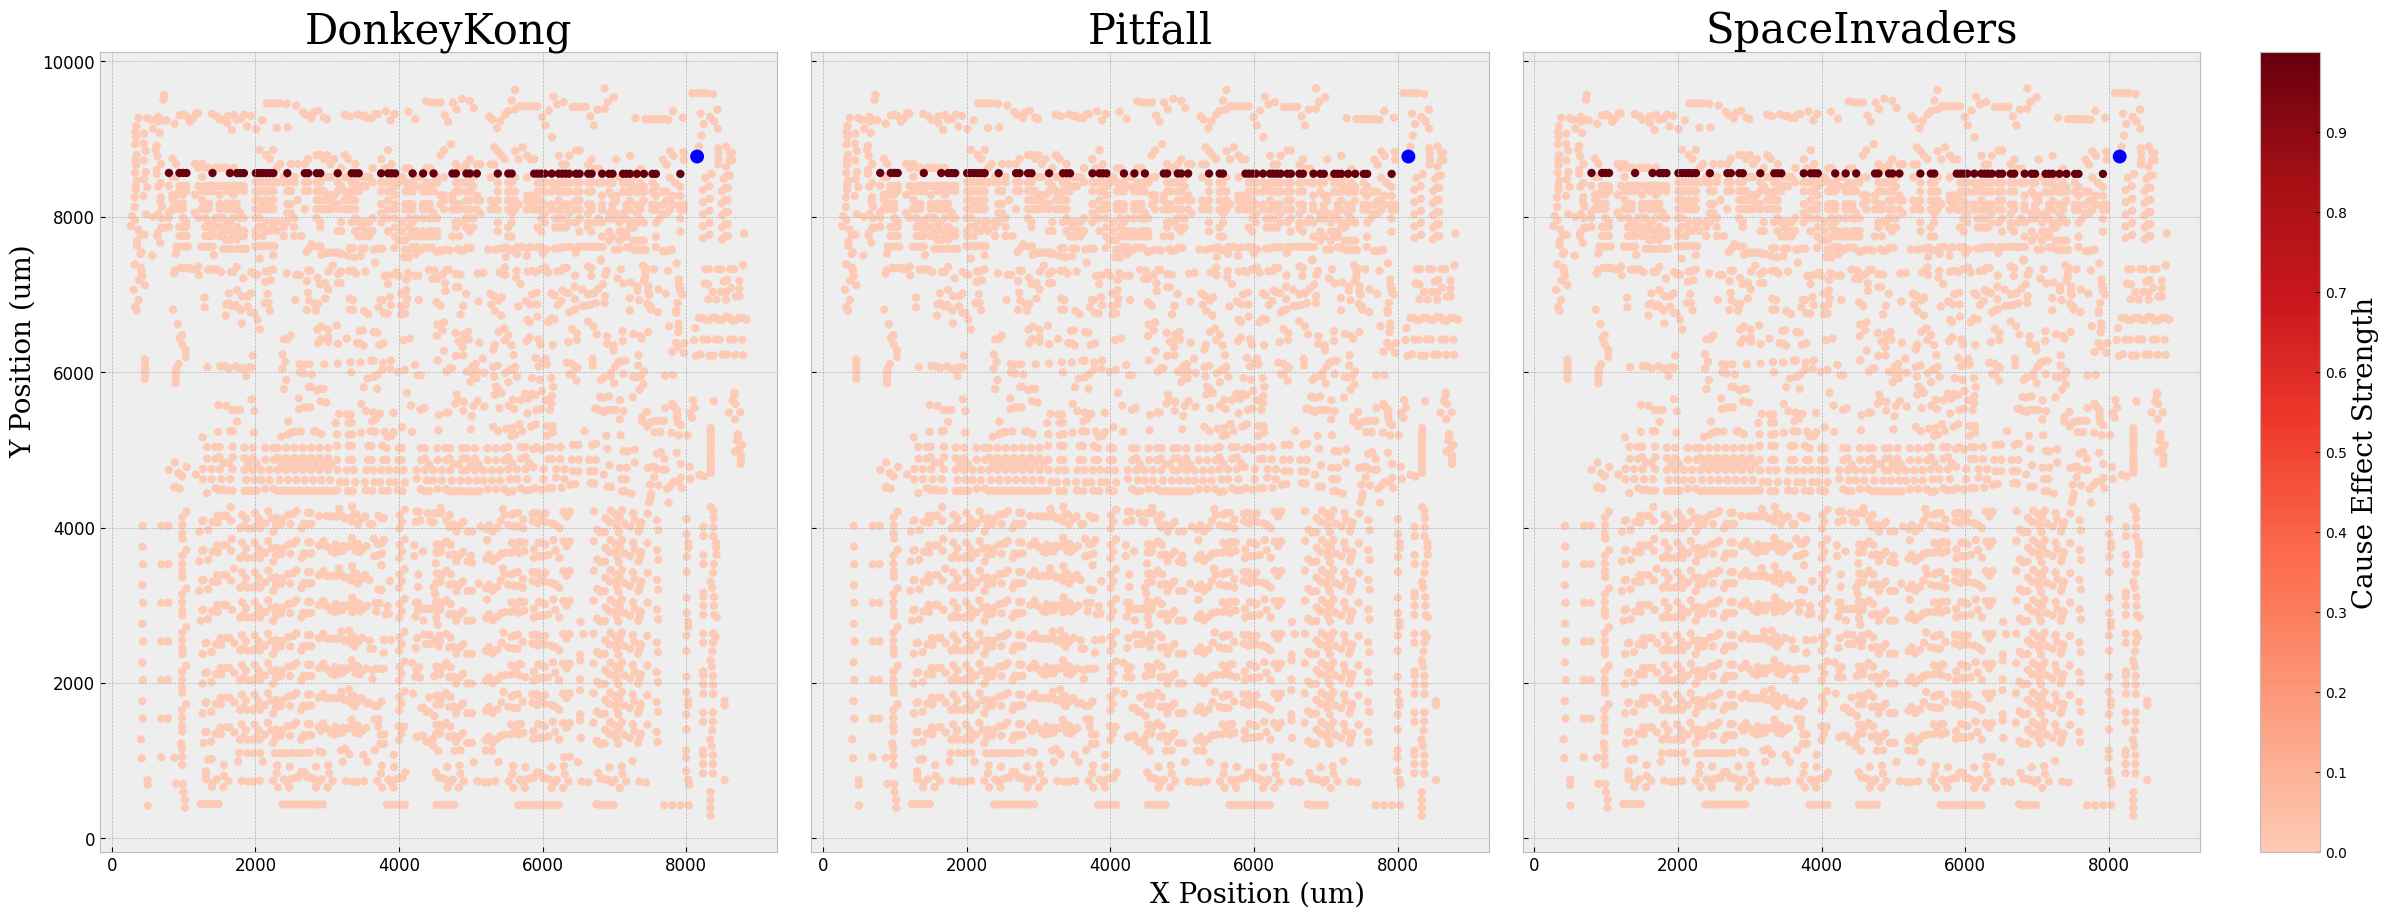

In [60]:
plot_cause_effect(target_idx=2328, save_dir='/project/lcd_v2/figure/Figure 2. Causal Effect/transistor_2328')

3355 (3510, 2) 0.4774581747061726
3355 (3510, 2) 0.4809726361681647
3355 (3510, 2) 0.4774581747061726


/tmp/ipykernel_2562/541596468.py:77: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, cax=plt.axes([0.82, 0.1, 0.02, 0.8]))


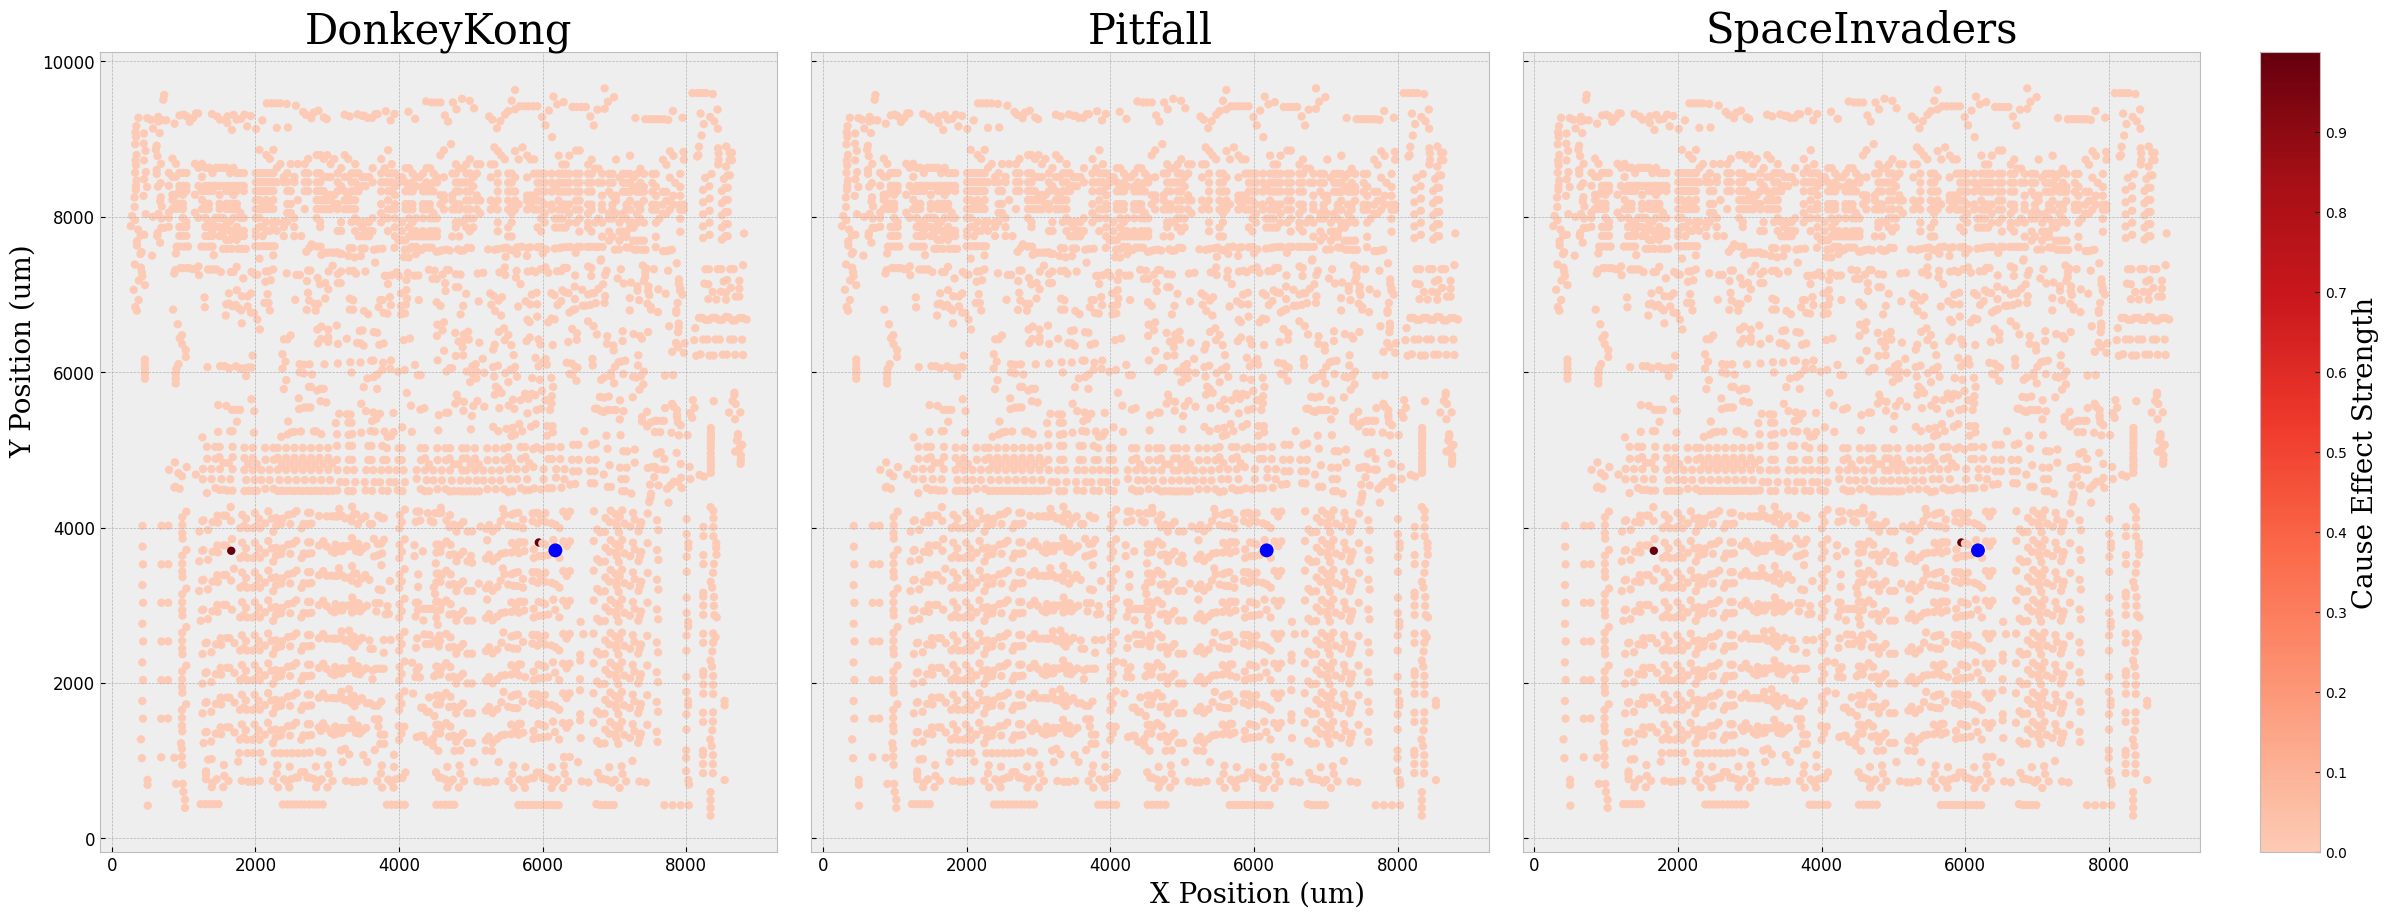

In [61]:
plot_cause_effect(target_idx=3355, save_dir='/project/lcd_v2/figure/Figure 2. Causal Effect/transistor_3355')

### Distribution of causal effect strength

In [23]:
from tqdm import tqdm
games = ['DonkeyKong', 'Pitfall', 'SpaceInvaders']
orig = np.load(os.path.join(root_dir, f'{game}/HR/window_{window}/Regular_3510_step_256_rec_400_window_{window}.npy'), mmap_mode='r')
potential_resultant = []
unique_perturb = get_perturb_config(orig)
effects = []
for i in tqdm(unique_perturb):
    effects.append(get_strength({'idx': i, 'game': 'DonkeyKong'}))

  0%|                                                                                                                                                                                  | 0/853 [00:00<?, ?it/s]

0 (3510, 90389) 0.15122687423081924


ValueError: negative dimensions are not allowed